In [1]:
!nvidia-smi

Sun May 24 17:52:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 665kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 13.1MB/s 
     |████████████████████████████████| 890kB 14.9MB/s 
     |████████████████████████████████| 3.8MB 22.5MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/184-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [0]:
import json, warnings, shutil
from scripts_step_lr_schedulers import *
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
import tweet_utility_preprocess_roberta_scripts_text as preprocess_text
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [0]:
# Unzip files
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/no_qa_fold_1.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/no_qa_fold_2.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/no_qa_fold_3.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/no_qa_fold_4.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/no_qa_fold_5.tar.gz'

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/complete_96/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,validation,train,train


# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 4,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 4,
  "question_size": 0,
  "N_FOLDS": 5,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1e-06


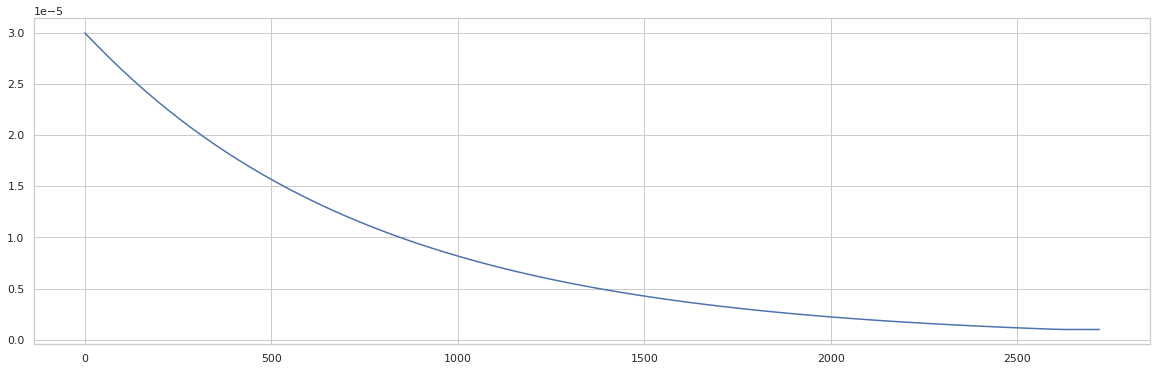

In [11]:
lr_min = 1e-6
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train'])
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
decay = .9987

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=1, lr_start=lr_max, lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    input_sentiment = layers.Input(shape=(3,), dtype=tf.float32, name='input_sentiment')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(last_hidden_state)
    x = layers.Dropout(.2)(x)

    x_start_negative = layers.Dense(1)(x)
    x_start_negative = layers.Flatten()(x_start_negative)
    y_start_negative = layers.Activation('softmax', name='y_start_negative')(x_start_negative)
    y_start_negative = layers.Multiply()([y_start_negative, input_sentiment[:,0]])
    
    x_start_neutral = layers.Dense(1)(x)
    x_start_neutral = layers.Flatten()(x_start_neutral)
    y_start_neutral = layers.Activation('softmax', name='y_start_neutral')(x_start_neutral)
    y_start_neutral = layers.Multiply()([y_start_neutral, input_sentiment[:,1]])
    
    x_start_positive = layers.Dense(1)(x)
    x_start_positive = layers.Flatten()(x_start_positive)
    y_start_positive = layers.Activation('softmax', name='y_start_positive')(x_start_positive)
    y_start_positive = layers.Multiply()([y_start_positive, input_sentiment[:,2]])

    y_start = layers.Add(name='y_start')([y_start_negative, y_start_neutral, y_start_positive])

    x_end_negative = layers.Dense(1)(x)
    x_end_negative = layers.Flatten()(x_end_negative)
    y_end_negative = layers.Activation('softmax', name='y_end_negative')(x_end_negative)
    y_end_negative = layers.Multiply()([y_end_negative, input_sentiment[:,0]])

    x_end_neutral = layers.Dense(1)(x)
    x_end_neutral = layers.Flatten()(x_end_neutral)
    y_end_neutral = layers.Activation('softmax', name='y_end_neutral')(x_end_neutral)
    y_end_neutral = layers.Multiply()([y_end_neutral, input_sentiment[:,1]])

    x_end_positive = layers.Dense(1)(x)
    x_end_positive = layers.Flatten()(x_end_positive)
    y_end_positive = layers.Activation('softmax', name='y_end_positive')(x_end_positive)
    y_end_positive = layers.Multiply()([y_end_positive, input_sentiment[:,2]])

    y_end = layers.Add(name='y_end')([y_end_negative, y_end_neutral, y_end_positive])
    
    model = Model(inputs=[input_ids, attention_mask, input_sentiment], outputs=[y_start, y_end])
    
    return model

# Train

In [0]:
def get_training_dataset(x_train, y_train, batch_size, buffer_size, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0], 'attention_mask': x_train[1], 'input_sentiment': x_train[2]}, 
                                                  {'y_start': y_train[0],'y_end': y_train[1]}))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size, repeated=False, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0], 'attention_mask': x_valid[1], 'input_sentiment': x_valid[2]}, 
                                                  {'y_start': y_valid[0],'y_end': y_valid[1]}))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_test_dataset(x_test, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices({'input_ids': x_test[0], 'attention_mask': x_test[1], 'input_sentiment': x_test[2]})
    dataset = dataset.batch(batch_size)
    return dataset

In [22]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
k_fold_best = k_fold.copy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))

    # Load data
    base_data_path = 'no_qa_fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    x_train_aux2 = np.load(base_data_path + 'x_train_aux2.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    x_valid_aux2 = np.load(base_data_path + 'x_valid_aux2.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']
    
    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=1, lr_start=lr_max, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))
    model.compile(optimizer, loss={'y_start': losses.CategoricalCrossentropy(label_smoothing=0.15),
                                   'y_end': losses.CategoricalCrossentropy(label_smoothing=0.15)})
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=False, verbose=1)
    checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    
    history = model.fit(get_training_dataset((*x_train, x_train_aux2), y_train, config['BATCH_SIZE'], AUTO, seed=SEED),
                        validation_data=(get_validation_dataset((*x_valid, x_valid_aux2), y_valid, config['BATCH_SIZE'], AUTO, repeated=False, seed=SEED)),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        callbacks=[checkpoint, es],
                        verbose=2).history
    
    history_list.append(history)
    model.save_weights(MODEL_BASE_PATH + 'last_' + model_path)

    # Make predictions (last model)
    predict_eval_df(k_fold, model, (*x_train, x_train_aux2), (*x_valid, x_valid_aux2), get_test_dataset, 
                    preprocess_text.decode, n_fold, tokenizer, config)

    # Make predictions (best model)
    model.load_weights(MODEL_BASE_PATH + model_path)
    predict_eval_df(k_fold_best, model, (*x_train, x_train_aux2), (*x_valid, x_valid_aux2), get_test_dataset, 
                    preprocess_text.decode, n_fold, tokenizer, config)


FOLD: 1
Epoch 1/4
687/687 - 278s - loss: 4.0488 - y_start_loss: 2.0169 - y_end_loss: 2.0319 - val_loss: 3.6459 - val_y_start_loss: 1.8415 - val_y_end_loss: 1.8044
Epoch 2/4
687/687 - 278s - loss: 3.6514 - y_start_loss: 1.8412 - y_end_loss: 1.8103 - val_loss: 3.5849 - val_y_start_loss: 1.8082 - val_y_end_loss: 1.7768
Epoch 3/4
687/687 - 278s - loss: 3.5480 - y_start_loss: 1.7947 - y_end_loss: 1.7533 - val_loss: 3.5701 - val_y_start_loss: 1.8051 - val_y_end_loss: 1.7651
Epoch 4/4
687/687 - 278s - loss: 3.5004 - y_start_loss: 1.7749 - y_end_loss: 1.7255 - val_loss: 3.5665 - val_y_start_loss: 1.8015 - val_y_end_loss: 1.7650

FOLD: 2
Epoch 1/4
687/687 - 278s - loss: 4.0538 - y_start_loss: 2.0171 - y_end_loss: 2.0367 - val_loss: 3.7100 - val_y_start_loss: 1.8638 - val_y_end_loss: 1.8462
Epoch 2/4
687/687 - 277s - loss: 3.6296 - y_start_loss: 1.8323 - y_end_loss: 1.7973 - val_loss: 3.6502 - val_y_start_loss: 1.8411 - val_y_end_loss: 1.8091
Epoch 3/4
687/687 - 277s - loss: 3.5270 - y_start_lo

# Model loss graph

Fold: 1


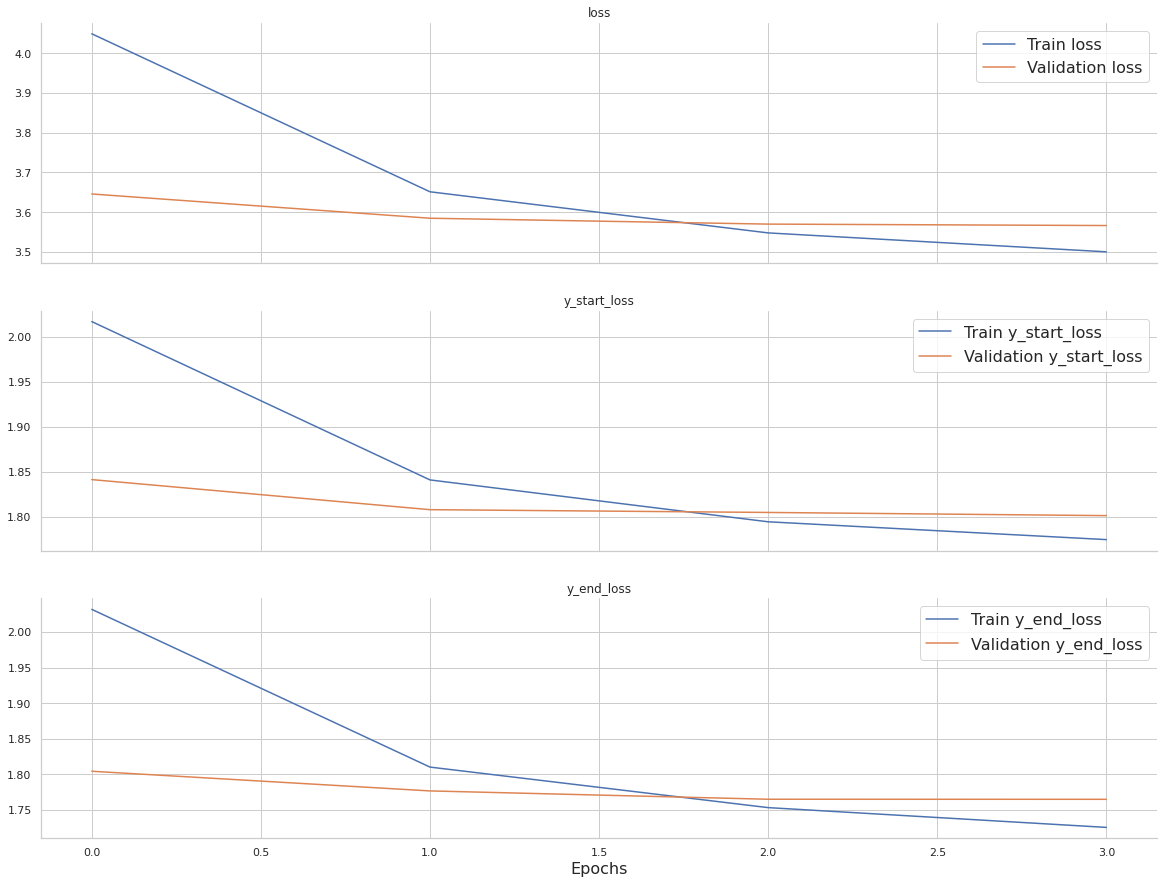

Fold: 2


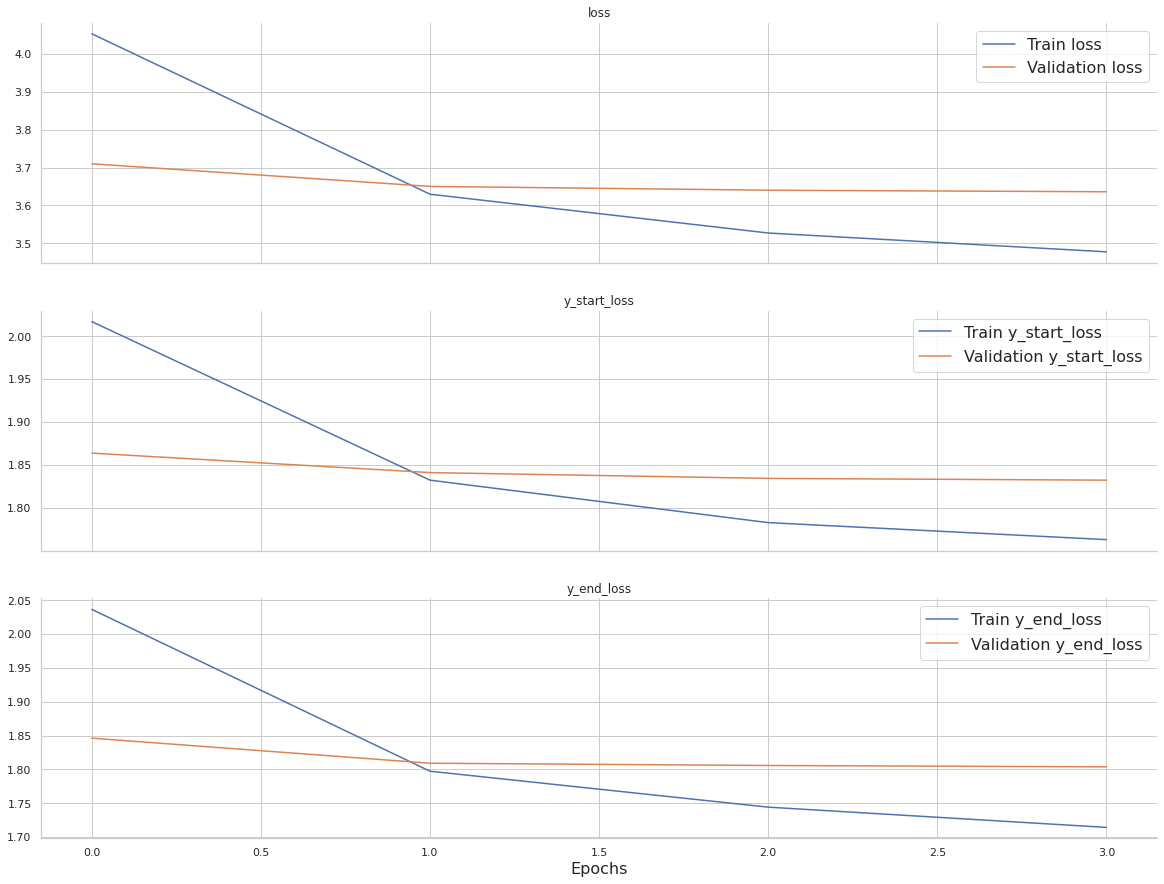

Fold: 3


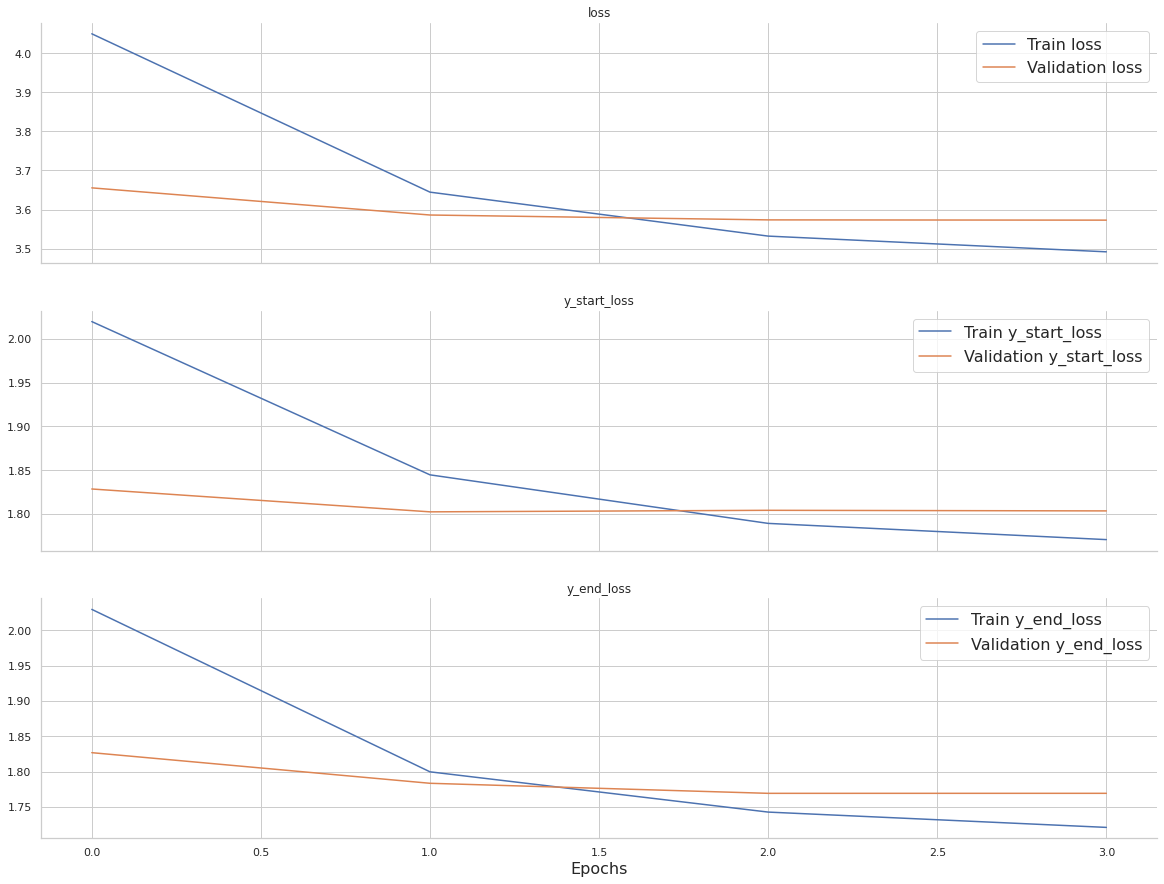

Fold: 4


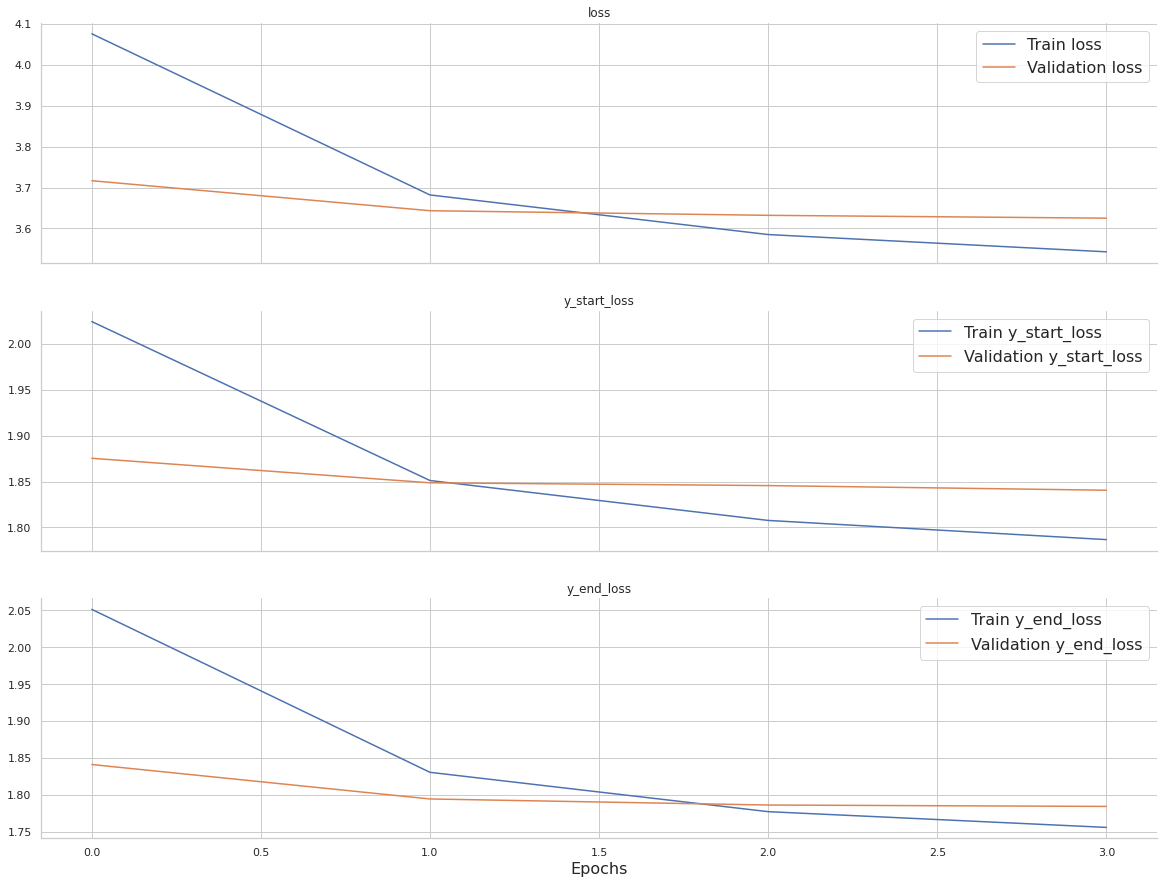

Fold: 5


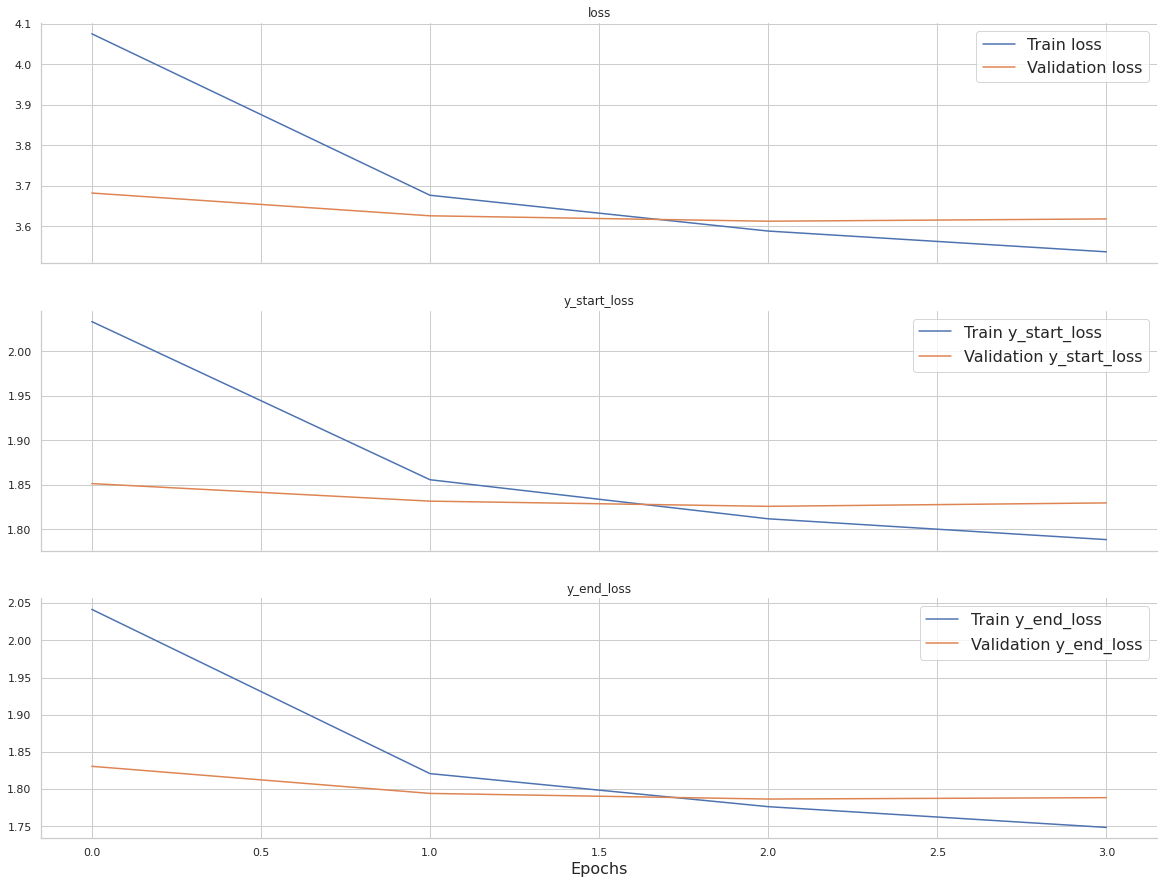

In [23]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation (last model)

In [24]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.734154,0.694102,0.040051,0.735274,0.694822,0.737593,0.691685,0.733676,0.698701,0.732698,0.687708,0.731527,0.697597
Sentiment negative,0.575760,0.502048,0.073712,0.576765,0.499518,0.581014,0.492666,0.573052,0.511836,0.573101,0.498863,0.574866,0.507358
Sentiment neutral,0.977583,0.976095,0.001488,0.976953,0.977844,0.977698,0.976008,0.977674,0.977227,0.978157,0.972993,0.977432,0.976402
Sentiment positive,0.562429,0.502942,0.059486,0.565956,0.505108,0.568566,0.503653,0.563214,0.507434,0.559409,0.489488,0.554999,0.509028
0 <= text wordCnt < 3,0.908444,0.901386,0.007058,0.915210,0.891791,0.903303,0.916115,0.905872,0.919948,0.909091,0.869658,0.908744,0.909420
3 <= text wordCnt < 10,0.781962,0.752660,0.029303,0.788259,0.741635,0.782406,0.754573,0.781381,0.759580,0.779732,0.745822,0.778033,0.761689
10 <= text wordCnt < 30,0.702302,0.655341,0.046961,0.700828,0.661800,0.707239,0.652236,0.701140,0.660241,0.701609,0.648554,0.700691,0.653873
30 <= text wordCnt < 100,0.665535,0.619044,0.046491,0.643490,0.651846,0.701829,0.482925,0.707966,0.573057,0.657482,0.602610,0.616909,0.784781
0 <= selected text wordCnt < 3,0.642076,0.569821,0.072256,0.646197,0.573116,0.661148,0.572503,0.628258,0.562240,0.634524,0.556481,0.640255,0.584762


# Model evaluation (best model)

In [25]:
display(evaluate_model_kfold(k_fold_best, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.733248,0.693478,0.039769,0.735274,0.694822,0.737593,0.691685,0.733676,0.698701,0.732698,0.687708,0.726997,0.694475
Sentiment negative,0.574282,0.501482,0.072800,0.576765,0.499518,0.581014,0.492666,0.573052,0.511836,0.573101,0.498863,0.567477,0.504525
Sentiment neutral,0.977578,0.976062,0.001516,0.976953,0.977844,0.977698,0.976008,0.977674,0.977227,0.978157,0.972993,0.977406,0.976238
Sentiment positive,0.560874,0.501500,0.059374,0.565956,0.505108,0.568566,0.503653,0.563214,0.507434,0.559409,0.489488,0.547226,0.501816
0 <= text wordCnt < 3,0.908796,0.901386,0.007410,0.915210,0.891791,0.903303,0.916115,0.905872,0.919948,0.909091,0.869658,0.910505,0.909420
3 <= text wordCnt < 10,0.781275,0.751600,0.029675,0.788259,0.741635,0.782406,0.754573,0.781381,0.759580,0.779732,0.745822,0.774596,0.756391
10 <= text wordCnt < 30,0.701218,0.654907,0.046311,0.700828,0.661800,0.707239,0.652236,0.701140,0.660241,0.701609,0.648554,0.695272,0.651703
30 <= text wordCnt < 100,0.665583,0.619877,0.045705,0.643490,0.651846,0.701829,0.482925,0.707966,0.573057,0.657482,0.602610,0.617146,0.788947
0 <= selected text wordCnt < 3,0.637545,0.566213,0.071332,0.646197,0.573116,0.661148,0.572503,0.628258,0.562240,0.634524,0.556481,0.617600,0.566726


# Visualize predictions

In [26]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,text_tokenCnt,selected_text_tokenCnt,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,10,10,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,13,3,sad,0.500000,sad,0.500000,sad,0.500000,sad,0.500000,sad,0.500000
2,my boss is bullying me...,bullying me,negative,0.166667,6,2,bullying,0.500000,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333,bullying,0.500000
3,what interview! leave me alone,leave me alone,negative,0.600000,6,3,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,17,4,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,27,27,some shameless plugging for the best rangers f...,0.833333,some shameless plugging for the best rangers f...,0.833333,http://www.dothebouncy.com/smf - some shameles...,1.000000,some shameless plugging for the best rangers f...,0.833333,some shameless plugging for the best rangers f...,0.833333
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,17,1,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,1.000000,3,3,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,3,3,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,19,7,wow... u just became cooler.,1.000000,wow...,0.200000,wow... u just became cooler.,1.000000,wow... u just became cooler.,1.000000,wow... u just became cooler.,1.000000
